## E-tivity   - Binary Logistic regression - Task A
There are many situations where some $y$ should be a noisy
representation of some function of $x_1,\ldots,x_p$, but the 
response outcomes $y$ are binary.

Binary logistic regression corresponds to this probabilistic model

$$
p\left(y|w^T x \right)=\phi(w^T x)^{y}(1-\phi(w^T x ))^{1-y}  \text{ for } y=0,1
$$

where $w \in \mathbb{R}^p$ is the vector if coefficient and $\phi(\cdot)$ is some sigmoid function,e.g.,

* Logistic function: $\phi(x)=1/(1+e^{-x})$
* probit function: $\phi(x)=0.5(1+\text{erf}(x/\sqrt{2}))$


Given $N$ training data, the likelihood function assuming that all the observations in the sample are independently Bernoulli distributed is

$$
{\displaystyle {\begin{aligned}L(\theta \mid x)&=\Pr(Y\mid X;\theta )\\&=\prod_{i=1}^Np(y_{i}\mid x_{i};\theta )\\&=\prod _{i=1}^N\phi(w^T x_{i})^{y_{i}}(1-\phi(w^T x_{i}))^{(1-y_{i})}\end{aligned}}}
$$

Our goal is to find the maximum likelihood estimate of the vector of the parameters $w$, that is to solve the optimisation problem

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p} \prod _{i=1}^N\phi(w^T x_{i})^{y_{i}}(1-\phi(w^T x_{i}))^{(1-y_{i})}
$$

The product of probability (that are numbers between $0$ and $1$) can become very small for large $N$
and can lead to arithmetic underflow problems.
To avoid this problem, one typically maximises the logarithm of the likelihood function (log transform). In fact, one can prove that for any nonnegative function

$$
\arg\max_{x} f(x) = \arg\max_{x} \log(x)  
$$

and, therefore, we actually solve:

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p}  \sum _{i=1}^{N}y_{i}\log(\phi(w^T x_{i}))+(1-y_{i})\log(1-\phi(w^T x_{i}))
 $$

which is maximized using optimization techniques.

**Reguralisation**
In general-recipe ML, reguralisation is used to reduce the problem of overfitting. 
Therefore, actually the problem we aim to solve is

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p}  \sum _{i=1}^{N}y_{i}\log(\phi(w^T x_{i}))+(1-y_{i})\log(1-\phi(w^T x_{i})) + \alpha||w||_2^2
 $$
 
 where $ \alpha$ is the reguralisation constant (a design parameter that is usually selected via cross-validation, note that $ \alpha\geq0$) and $||w||_2^2=\sum_{=1}^{p} w_i^2$. 


We assume that you know how logistic regression works: (i) how to compute the predicted probability; (ii) how to return the predicted class.


## Task A
Part 1 Theorethical questions: 

    What type of optimisation problem is it?
    1. Is it univariate or multivariate?
    2. Is it linear or nonlinear?
    3. Is it convex or not? (google it and cite your font, how is the fast way to prove it?)
    4. Is it constrained?

### Task A - Answers
1. Univariate
2. Nonlinear
3. Concave
4. Yes as α >= 0

Part 2: The goal of this part is to reimplement **totally** from scratch the class LogisticRegression, that mimics the corresponding class in `Sklearn`. 
* The class must be flexible: the user can choose any type of differentiable (w.r.t. the parameters $w$) sigmoid function and the class must work for any number of features $p$ (suggestion: use `autograd` library). 
* As optimizer you should use `local_descent` with  `line_research`, see the Webinar 1 notebook.


You can implement the class either in Python or in Julia.

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from autograd.scipy.special import erf
import autograd.numpy as np
from autograd import grad
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Golden Retio
ϕ = (1 + sqrt(5))/2

In [2]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
ind = np.where((y==0) | (y==1))[0] # we only have two classes now
X = X[ind,:]
y = y[ind]

In [3]:
y = np.reshape(y, (y.shape[0], 1))
print(y.shape)
print(X.shape)

(100, 1)
(100, 4)


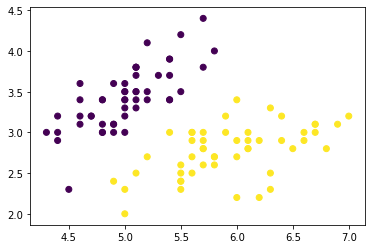

In [4]:
_ = plt.scatter(X[:, 0], X[:, 1], c=y.flatten() )

### Line Search Implementation
The following functions are required to invoke the line search method for optimization

In [5]:
def bracket_minimum(f, x=0, s=1e-2, k=2.0): #From the Book, pag.36
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a<c else (c, a)        
        a, ya, b, yb = b, yb, c, yc
        s *= k
        
def golden_section_search(f, a, b, max_iter, plotting=True): #from the Book pag.41
    a0 =a
    b0=b
    ρ = φ-1
    d = ρ * b + (1 - ρ)*a
    yd = f(d)
    for i in range(max_iter-1):
        c = ρ*a + (1 - ρ)*b
        yc = f(c)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c   
        if plotting==True:
            plt.figure()
            xx = np.linspace(a0,b0,100)
            plt.plot(xx,f(xx))
            plt.scatter(np.array([a,b]),np.array([a,b])*0)
            plt.scatter(np.array([a,b]),np.array([f(a),f(b)]))

    return (a, b) if a<b else (b, a)

def line_search(f, x, d, ϵ_x=0.0001, ϵ_d=0.0001):
    term = False
    if np.linalg.norm(d) < ϵ_d:
        term = True
        return x
    objective = lambda α : f(x + α*d)
    a, b = bracket_minimum(objective)
    a, b = golden_section_search(objective, a, b, max_iter = 5, plotting=False)
    α = (a+b)/2
    if np.linalg.norm(x+a*d-x)<ϵ_x:
        term = True
    return x + α*d, term

def local_descent(β,cost, gradient,steps=1, α=None, ϵ_x=0.0001, ϵ_d=0.0001,  plotting=False):
    Tmp = [β]
    for iteration in range(steps):
        d = gradient(β)
        d = -d/np.linalg.norm(d)
        β, term = line_search(cost, β, d, ϵ_x=ϵ_x, ϵ_d=ϵ_d)
        if term == True:
            break
        Tmp.append(β)
    return Tmp

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Logistic Regression Implementation
The following is an implementation of logistic regression that uses cross entropy as it's cost function and local descent as the optimizer. 

In [8]:
class Generic_LogisticRegression():
    def __init__(self, θ, sigmoid, α=0.01):
        self.θ = θ #initial value of the parameter
        self.sigmoid = sigmoid #a sigmoid function that squezes the input into [0,1]
        self.α = α #reguralisation parameter
        
    def __prob(self, x, theta):
        '''
        Helper that uses sigmoid fucntion to squash the result between zero and one
        '''
        return self.sigmoid(np.dot(x, theta))
    
    def fit(self,x,y):  
        def cost_i(θ):
            '''
            Cost function using cross entropy cost
            '''
            h = self.__prob(x, θ)
            m = X.shape[0]
            # Cross Entropy function
            cost = -(1.0/m) * (np.dot(y.T, np.log(h)) + np.dot((1-y.T), np.log(1-h))) + (self.α * np.sum(θ**2))
            return cost
        
        # Function to calculate gradient
        gradcost = grad(cost_i)
        
        # Updated value for θ
        θ = local_descent(self.θ, cost_i, gradcost, steps=30, α=self.α, ϵ_x=0.0001, ϵ_d=0.0001, plotting=False)
        self.θ = θ[-1]
    
    def predict_proba(self, x):
        return self.__prob(x, self.θ)
    
    def predict(self, x):
        return np.where(self.predict_proba(x) >= 0.5, 1, 0)       

In [9]:
theta = np.zeros((X.shape[1], 1))
GLR = Generic_LogisticRegression(theta, sigmoid)
GLR.fit(X,y)
y_pred = GLR.predict(X)
print(y_pred)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


### Instructions for Use
To use this implementation of logistic regression perform the following steps:
1. Initialize the weights to np.zeros((X.shape[1], 1))
2. Initialize the class passing the weights and reference to sigmoid function
3. Fit data and labels to class
4. Call predict and predict_proba methods to get results